# Road sign recognition - rsignNet

The objective of this project is to develop convolution neural net for road sign classification using real world images.  Data source: https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed?select=datasets_preparing.py

In addition to develop custom CNN, transfer learning using pre-trained neural net (VGG16) will also be implemented to serve as performance benchmark.

<span style="color:red">Feedback from presentation</span>: use more flexible per-trained neural net (VGG19) to see if it can performance better. VGG 19 model is added in Section 4.2 and model performance will be compared with the rest of the models.

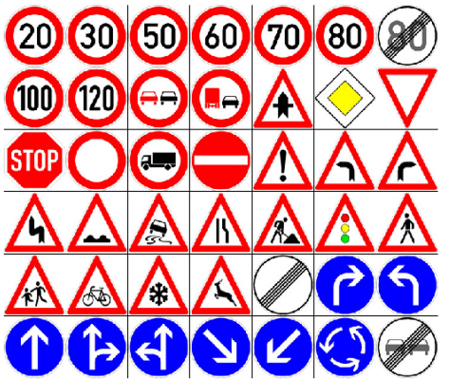

In [1]:
%matplotlib inline
%load_ext tensorboard

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import pickle, os, datetime, shutil
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# manage tensorboard log directory
dir = r'./logs/'
if os.path.isdir(dir):
    shutil.rmtree(dir)

os.mkdir(dir)

# SECTION 1. Exploratory Data Analysis
* Understand input datatype & data class distribution
* The image set contains 104,029 images, which is split to train, test and validation. 

In [4]:
# Load RGB road sign image dataset
with open(r'./data/data0.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [5]:
# check data structure
for k in ['x_train', 'y_train', 'x_validation', 'y_validation', 'x_test', 'y_test']:
    print('{} sample count: {:,}'.format(k, len(data[k])))

x_train sample count: 86,989
y_train sample count: 86,989
x_validation sample count: 4,410
y_validation sample count: 4,410
x_test sample count: 12,630
y_test sample count: 12,630


Text(0.5, 1.0, 'training data frequency')

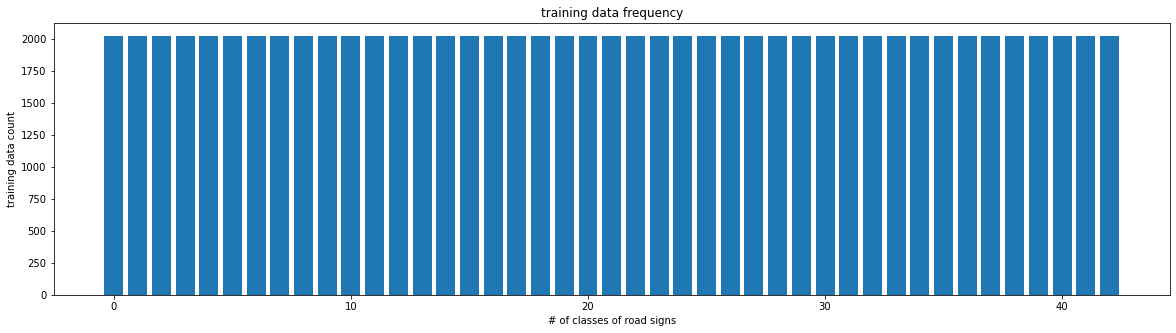

In [6]:
# check if there is inbalance dataset problem
_uniqueClass, _frequency = np.unique(data['y_train'], return_counts=True)

plt.rcParams['figure.figsize'] = [20, 5]
fig = plt.figure()

plt.bar(x=_uniqueClass, height=_frequency)
plt.xlabel('# of classes of road signs')
plt.ylabel('training data count')
plt.title('training data frequency')

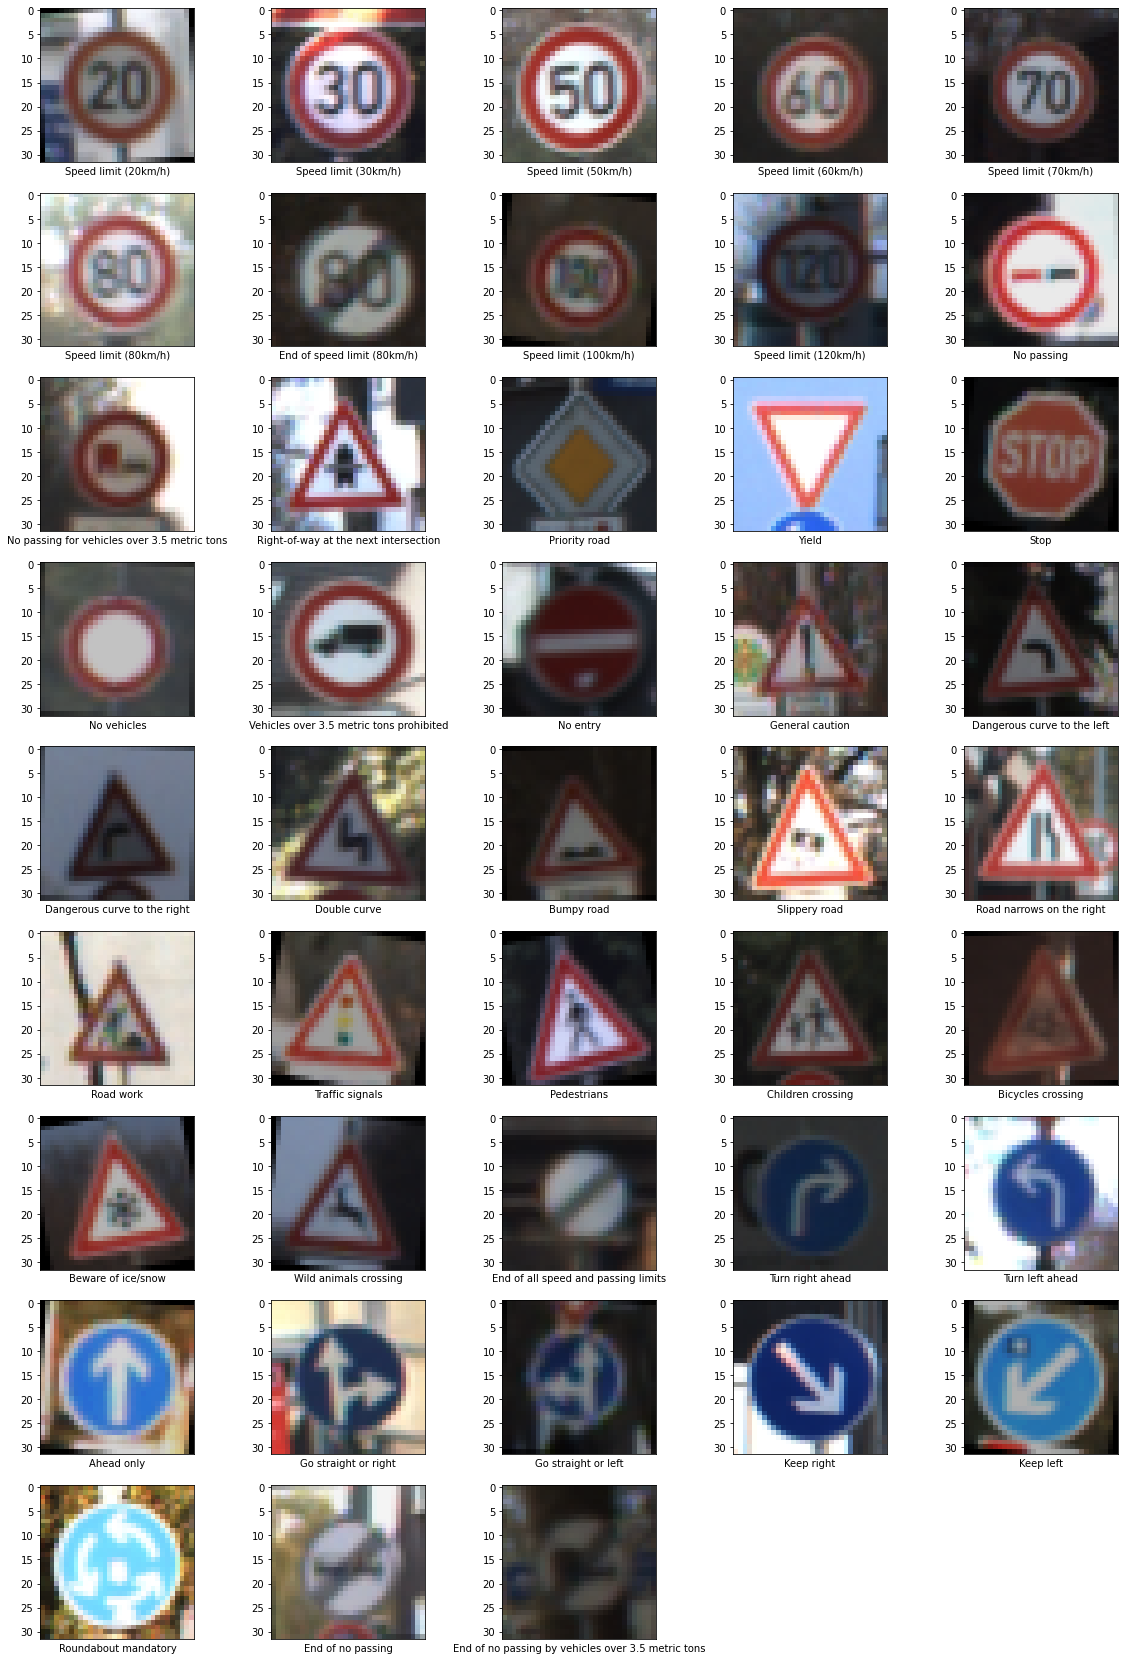

In [7]:
# sample images for each class
sample_images = [411, 42, 139, 86, 55, 
                103, 290, 6, 32, 52, 
                161, 80, 28, 29, 16, 
                83, 90, 130, 17, 191,
                100, 68, 74, 298, 300, 
                377, 499, 124, 41, 170, 
                84, 36, 438, 91, 27, 
                18, 76, 97, 2, 73, 
                62, 166, 182]

# re-arrange image dimensions from [:, 3, 32, 32] to [:, 32, 32, 3]
data4display = np.moveaxis(data['x_train'], 1, -1)

# plotting sample images
plt.rcParams['figure.figsize'] = [20, 30]
fig_sampleImage = plt.figure()
rows, columns = (9, 5)
for i in range(1, len(_uniqueClass)+1):
    _img = data4display[sample_images[i-1]]
    fig_sampleImage.add_subplot(rows, columns, i)
    plt.imshow(_img)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.xlabel(data['labels'][i-1])

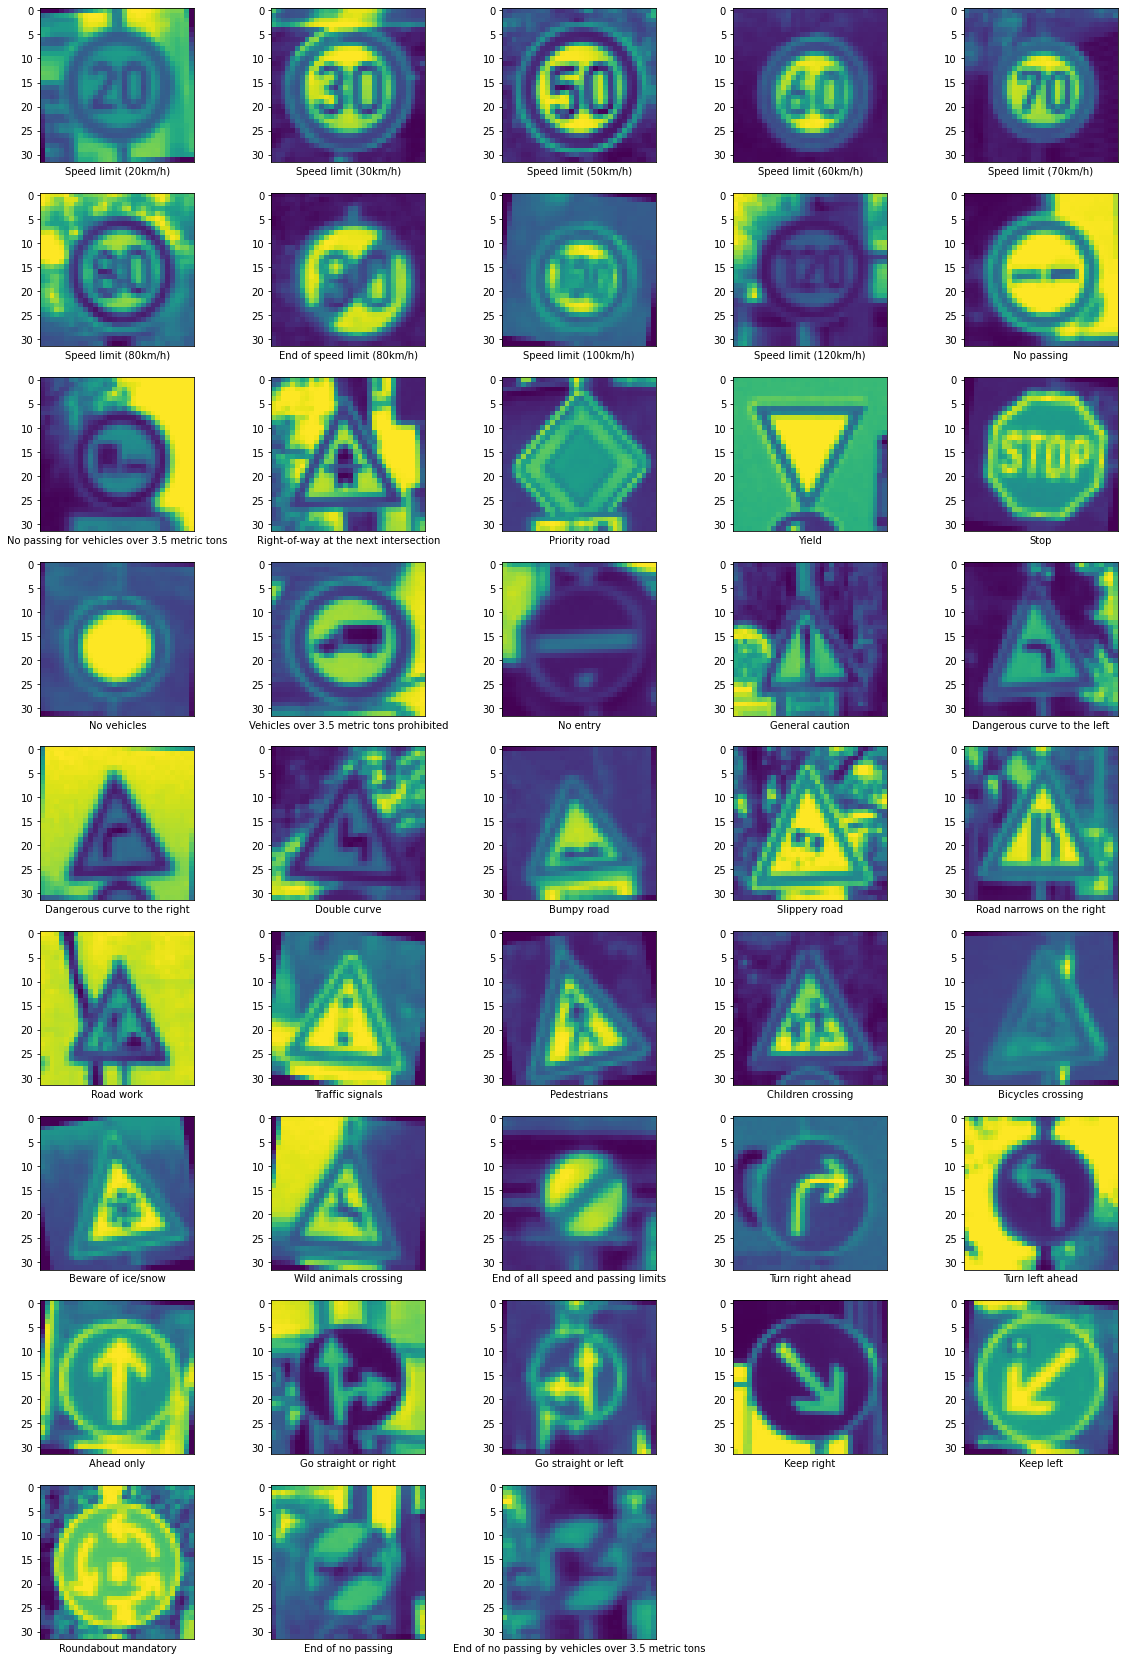

In [8]:
# convert RGB images to gray scale images for display
data4display_g = np.zeros((data4display.shape[0], 32, 32, 1))
data4display_g[:, :, :, 0] = data4display[:, :, :, 0] * 0.299 + data4display[:, :, :, 1] * 0.587 + data4display[:, :, :, 2] * 0.114
plt.rcParams['figure.figsize'] = [20, 30]
fig_sampleImage = plt.figure()
rows, columns = (9, 5)
for i in range(1, len(_uniqueClass)+1):
    _img = data4display_g[sample_images[i-1]]
    fig_sampleImage.add_subplot(rows, columns, i)
    plt.imshow(_img)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.xlabel(data['labels'][i-1])

# SECTION 2. Data Preprocessing
This section is used to prepare the data for the model:
> - Re-arrange the data dimensions
> - One-hot encode target

## 2.1 Processing RGB images

In [9]:
# rearrange training/validation/testing data dimension for RGB images from [:, 3, 32, 32] to [:, 32, 32, 3]
# scale RGB value by 255
x_train = np.moveaxis(data['x_train'], 1, -1)
x_train = x_train.astype(float)
x_train /= 255.
x_validation = np.moveaxis(data['x_validation'], 1, -1)
x_validation = x_validation.astype(float)
x_validation /=255.
x_test = np.moveaxis(data['x_test'], 1, -1)
x_test = x_test.astype(float)
x_test /= 255.

# one-hot encode target
y_train = data['y_train'][...,None]
y_validation = data['y_validation'][...,None]
y_test = data['y_test'][...,None]

y_train = tf.one_hot(y_train, depth=43)
y_validation = tf.one_hot(y_validation, depth=43)
y_test = tf.one_hot(y_test, depth=43)

# fixing the target dimension
y_train = np.squeeze(y_train, axis=1)
y_validation = np.squeeze(y_validation, axis=1)
y_test = np.squeeze(y_test, axis=1)

## 2.2 Convert RGB image to gray scale images

In [10]:
# covnerting rgb images to gray scale images
# based on convertion formula: imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

x_train_g = np.zeros((x_train.shape[0], 32, 32, 1))
x_validation_g = np.zeros((x_validation.shape[0], 32, 32, 1))
x_test_g = np.zeros((x_test.shape[0], 32, 32, 1))

x_train_g[:, :, :, 0] = x_train[:, :, :, 0] * 0.299 + x_train[:, :, :, 1] * 0.587 + x_train[:, :, :, 2] * 0.114
x_validation_g[:, :, :, 0] = x_validation[:, :, :, 0] * 0.299 + x_validation[:, :, :, 1] * 0.587 + x_validation[:, :, :, 2] * 0.114
x_test_g[:, :, :, 0] = x_test[:, :, :, 0] * 0.299 + x_test[:, :, :, 1] * 0.587 + x_test[:, :, :, 2] * 0.114

# SECTION 3. Custom CNN models
* Two custom convolutional neural nets one with RGB images and the other with gray scale images
* Create simple CNN with 3 convolutional layers, 2 fully connected dense layer and 1 output layer with 43 classes
* Normalize training batch
* Include 2 dropout layer with 50% rate
* Early stop criteria is also implemented conditioning on maximum validation accuracy

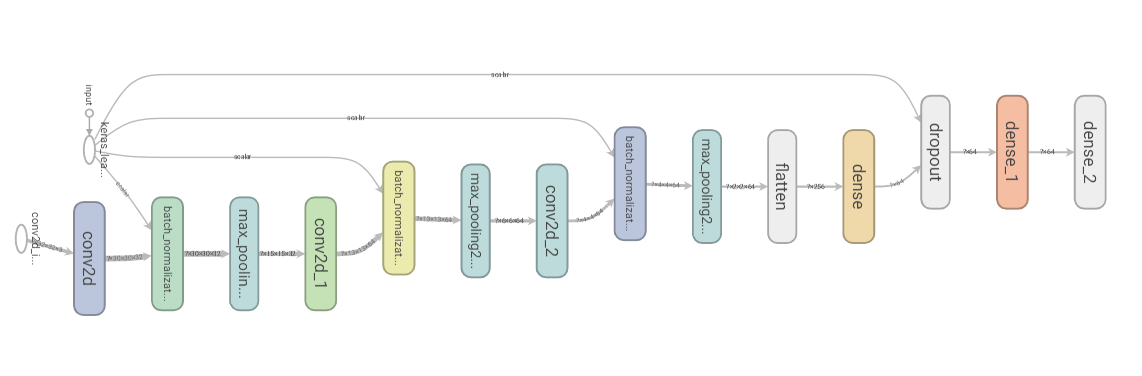

## 3.1 Custom CNN model - RGB images

In [11]:
#initialize rsignNet model
rsignNet = models.Sequential()

#convolution layers
rsignNet.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
rsignNet.add(layers.BatchNormalization())
rsignNet.add(layers.MaxPooling2D((2, 2)))
rsignNet.add(layers.Conv2D(64, (3, 3), activation='relu'))
rsignNet.add(layers.BatchNormalization())
rsignNet.add(layers.MaxPooling2D((2, 
rsignNet.add(layers.Conv2D(64, (3, 3), activation='relu'))
rsignNet.add(layers.BatchNormalization())
rsignNet.add(layers.MaxPooling2D((2, 2)))

# fully connected layers
rsignNet.add(layers.Flatten())
rsignNet.add(layers.Dense(64, activation='relu'))
rsignNet.add(layers.Dropout(0.5))
rsignNet.add(layers.Dense(64, activation='relu'))
rsignNet.add(layers.Dropout(0.5))

#output layer, matching 43 classes of road signs
rsignNet.add(layers.Dense(43, activation='softmax'))

In [12]:
rsignNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [13]:
rsignNet.compile(optimizer='adam', 
                 loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                 metrics=['accuracy'])

In [14]:
# initiate tensorboard
utime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/rsignNet_rgb_" + utime
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
# define early stop criteria
es_rsignNet = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [16]:
# fit rsignNet model
rsignNet_performance = rsignNet.fit(x_train, 
                                    y_train,
                                    epochs=50,
                                    validation_data=(x_test, y_test),
                                    callbacks=[tensorboard_callback, es_rsignNet])

Epoch 1/50
   1/2719 [..............................] - ETA: 0s - loss: 3.7679 - accuracy: 0.0312WARNING:tensorflow:From C:\ProgramData\Miniconda3\envs\ML\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2719/2719 [==============================] - 35s 13ms/step - loss: 3.5399 - accuracy: 0.2614 - val_loss: 3.3775 - val_accuracy: 0.4226
Epoch 2/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.3072 - accuracy: 0.4974 - val_loss: 3.2488 - val_accuracy: 0.5524
Epoch 3/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1984 - accuracy: 0.6055 - val_loss: 3.1490 - val_accuracy: 0.6519
Epoch 4/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1379 - accuracy: 0.6655 - val_loss: 3.1072 - val_accuracy: 0.6930
Epoch 5/50
2719/2719 [=================

In [17]:
# save RGB model
rsignNet.save("models/rsignNet_"+utime)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/rsignNet_20220515-024330\assets


## 3.2 Custom CNN model - gray scale images
* re-configurate the same model structure as RGB model to use gray scale image. Input shape is updated to (32, 32, 1)

In [18]:
#initialize rsignNet model
rsignNet_g = models.Sequential()

#convolution layers
rsignNet_g.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
rsignNet_g.add(layers.BatchNormalization())
rsignNet_g.add(layers.MaxPooling2D((2, 2)))
rsignNet_g.add(layers.Conv2D(64, (3, 3), activation='relu'))
rsignNet_g.add(layers.BatchNormalization())
rsignNet_g.add(layers.MaxPooling2D((2, 2)))
rsignNet_g.add(layers.Conv2D(64, (3, 3), activation='relu'))
rsignNet_g.add(layers.BatchNormalization())
rsignNet_g.add(layers.MaxPooling2D((2, 2)))

# fully connected layers
rsignNet_g.add(layers.Flatten())
rsignNet_g.add(layers.Dense(64, activation='relu'))
rsignNet_g.add(layers.Dropout(0.5))
rsignNet_g.add(layers.Dense(64, activation='relu'))
rsignNet.add(layers.Dropout(0.5))

#output layer, matching 43 classes of road signs
rsignNet_g.add(layers.Dense(43, activation='softmax'))

rsignNet_g.compile(optimizer='adam', 
                   loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

# initiate tensorboard
utime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/rsignNet_g_" + utime
tensorboard_callback_g = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# define early stop criteria
es_rsignNet_g = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# fit rsignNet model
rsignNet_g_performance = rsignNet_g.fit(x_train_g, 
                                        y_train,
                                        epochs=50,
                                        validation_data=(x_test_g, y_test),
                                        callbacks=[tensorboard_callback_g, es_rsignNet_g])

# save gray scale model
rsignNet_g.save("models/rsignNet_g_"+utime)

Epoch 1/50
2719/2719 [==============================] - 35s 13ms/step - loss: 3.4106 - accuracy: 0.3939 - val_loss: 3.3897 - val_accuracy: 0.4114
Epoch 2/50
2719/2719 [==============================] - 34s 12ms/step - loss: 3.2411 - accuracy: 0.5609 - val_loss: 3.2962 - val_accuracy: 0.5040
Epoch 3/50
2719/2719 [==============================] - 34s 12ms/step - loss: 3.1923 - accuracy: 0.6091 - val_loss: 3.2524 - val_accuracy: 0.5478
Epoch 4/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1606 - accuracy: 0.6404 - val_loss: 3.2505 - val_accuracy: 0.5496
Epoch 5/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1467 - accuracy: 0.6539 - val_loss: 3.1970 - val_accuracy: 0.6032
Epoch 6/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1346 - accuracy: 0.6659 - val_loss: 3.2012 - val_accuracy: 0.5984
Epoch 7/50
2719/2719 [==============================] - 33s 12ms/step - loss: 3.1306 - accuracy: 0.6698 - val_loss: 3.2197 -

# SECTION 4. Transfer Learning using Pre-Trained Model (VGG16)
* leverage convolutional neural network with pre-trained weights(imagenet) and re-configurate the FC layers for road sign classification

* transfer learning on VGG16 and VGG19 models are being implemented below.

## Section 4.1 Transfer Learning with VGG16 Model 

* All weights of convolutional layers are being set to untrainable
* Fully connected layers will have 128 neurons each with 50% dropout rate to mitigate overfitting


In [19]:
# Load VGG16 model without fully connected layer & disable training on the convolutional layers
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))
vgg16.trainable = False

In [20]:
#initialize VGG16 transfer learning model
vgg16_tl = models.Sequential()

# add pre-trained VGG16 layers
vgg16_tl.add(vgg16)

# add FC layers
vgg16_tl.add(layers.Flatten())
vgg16_tl.add(layers.Dense(256, activation='relu'))
vgg16_tl.add(layers.Dropout(0.5))
vgg16_tl.add(layers.Dense(256, activation='relu'))
vgg16_tl.add(layers.Dropout(0.5))

# add output layer with softmax activation function
vgg16_tl.add(layers.Dense(43, activation='softmax'))

In [21]:
vgg16_tl.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 43)               

In [22]:
# initiate tensorboard
utime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/vgg16_" + utime
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
es_vgg16_tl = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [24]:
Adam = keras.optimizers.Adam(learning_rate=0.001)
vgg16_tl.compile(optimizer=Adam,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [25]:
performance_vgg16_tl = vgg16_tl.fit(x_train, 
                                y_train,
                                epochs=50,
                                validation_data=(x_validation, y_validation),
                                callbacks=[tensorboard_callback2, es_vgg16_tl])

Epoch 1/50
2719/2719 [==============================] - 97s 36ms/step - loss: 3.5851 - accuracy: 0.2179 - val_loss: 3.5511 - val_accuracy: 0.2499
Epoch 2/50
2719/2719 [==============================] - 96s 35ms/step - loss: 3.4673 - accuracy: 0.3370 - val_loss: 3.4988 - val_accuracy: 0.3014
Epoch 3/50
2719/2719 [==============================] - 96s 35ms/step - loss: 3.4103 - accuracy: 0.3934 - val_loss: 3.4616 - val_accuracy: 0.3379
Epoch 4/50
2719/2719 [==============================] - 96s 35ms/step - loss: 3.3793 - accuracy: 0.4240 - val_loss: 3.4510 - val_accuracy: 0.3515
Epoch 5/50
2719/2719 [==============================] - 96s 35ms/step - loss: 3.3586 - accuracy: 0.4438 - val_loss: 3.4590 - val_accuracy: 0.3415
Epoch 6/50
2719/2719 [==============================] - 95s 35ms/step - loss: 3.3461 - accuracy: 0.4557 - val_loss: 3.4522 - val_accuracy: 0.3456
Epoch 7/50
2719/2719 [==============================] - 96s 35ms/step - loss: 3.3330 - accuracy: 0.4685 - val_loss: 3.4416 -

In [26]:
# save VGG16 model
vgg16_tl.save("models/vgg16_"+utime)

INFO:tensorflow:Assets written to: models/vgg_20220515-030944\assets


## Section 4.2 Transfer Learning with VGG19 Model
* All weights of convolutional layers are being set to untrainable
* Fully connected layers will have 128 neurons each with 50% dropout rate to mitigate overfitting

In [27]:
# Load VGG19 model without fully connected layer & disable training on the convolutional layers
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(32,32,3))
vgg19.trainable = False

In [28]:
#initialize VGG16 transfer learning model
vgg19_tl = models.Sequential()

# add pre-trained VGG16 layers
vgg19_tl.add(vgg16)

# add FC layers
vgg19_tl.add(layers.Flatten())
vgg19_tl.add(layers.Dense(128, activation='relu'))
vgg19_tl.add(layers.Dropout(0.5))
vgg19_tl.add(layers.Dense(128, activation='relu'))
vgg19_tl.add(layers.Dropout(0.5))

# add output layer with softmax activation function
vgg19_tl.add(layers.Dense(43, activation='softmax'))

In [29]:
# initiate tensorboard
utime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/vgg19_" + utime
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
es_vgg19_tl = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [31]:
Adam = keras.optimizers.Adam(learning_rate=0.001)
vgg19_tl.compile(optimizer=Adam,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [32]:
performance_vgg19_tl = vgg19_tl.fit(x_train, 
                                y_train,
                                epochs=50,
                                validation_data=(x_validation, y_validation),
                                callbacks=[tensorboard_callback2, es_vgg16_tl])

Epoch 1/50
2719/2719 [==============================] - 99s 36ms/step - loss: 3.6155 - accuracy: 0.1885 - val_loss: 3.5350 - val_accuracy: 0.2687
Epoch 2/50
2719/2719 [==============================] - 95s 35ms/step - loss: 3.5051 - accuracy: 0.3007 - val_loss: 3.4907 - val_accuracy: 0.3127
Epoch 3/50
2719/2719 [==============================] - 95s 35ms/step - loss: 3.4550 - accuracy: 0.3501 - val_loss: 3.4824 - val_accuracy: 0.3213
Epoch 4/50
2719/2719 [==============================] - 95s 35ms/step - loss: 3.4253 - accuracy: 0.3797 - val_loss: 3.4704 - val_accuracy: 0.3306
Epoch 5/50
2719/2719 [==============================] - 94s 35ms/step - loss: 3.4050 - accuracy: 0.3992 - val_loss: 3.4587 - val_accuracy: 0.3429
Epoch 6/50
2719/2719 [==============================] - 95s 35ms/step - loss: 3.3878 - accuracy: 0.4161 - val_loss: 3.4564 - val_accuracy: 0.3447
Epoch 7/50
2719/2719 [==============================] - 94s 34ms/step - loss: 3.3735 - accuracy: 0.4293 - val_loss: 3.4316 -

In [33]:
# save VGG19 model
vgg19_tl.save("models/vgg19_"+utime)

INFO:tensorflow:Assets written to: models/vgg_20220515-033352\assets


# SECTION 5. Model performance
## Section 5.1 Load model performance in Tensorboard

In [42]:
# Loading model training/validation performance in tensorboard
%tensorboard --logdir logs/fit --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1344.

## Section 5.2 Plot model performance in Matplotlib

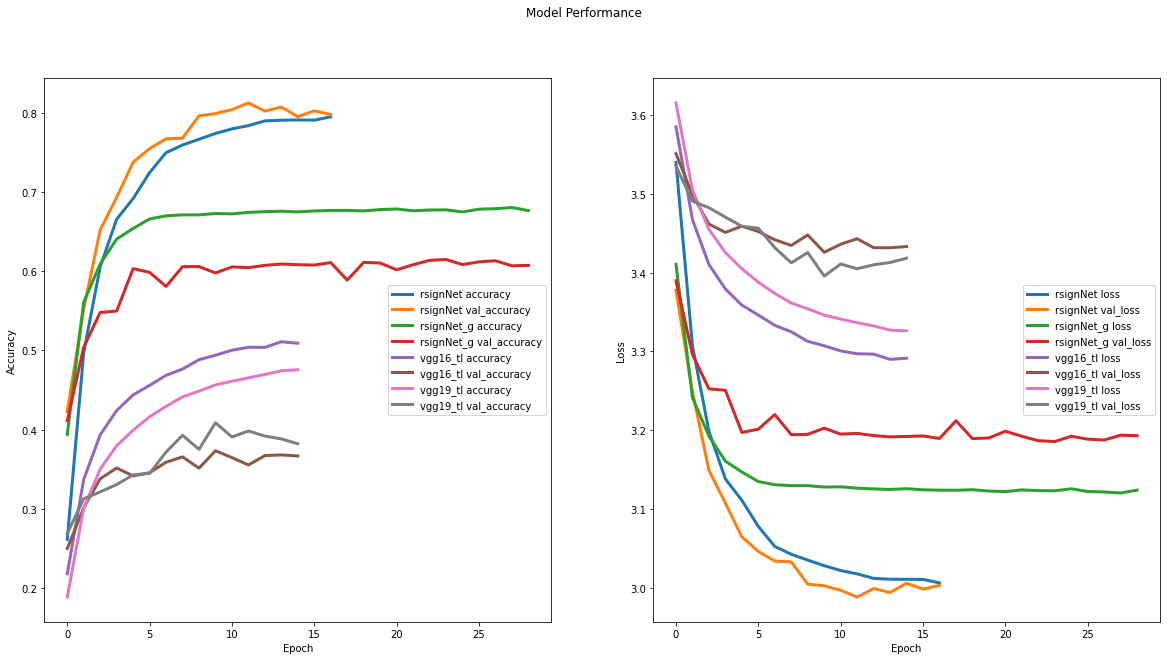

In [35]:
# Visualize model performance using matplotlib
performance = {'rsignNet': rsignNet_performance, 
               'rsignNet_g': rsignNet_g_performance, 
               'vgg16_tl':performance_vgg16_tl, 
               'vgg19_tl':performance_vgg19_tl}

plt.rcParams['figure.figsize'] = [20, 10]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Model Performance')

for model_name, model_history in performance.items():
    axs[0].plot(model_history.history['accuracy'], label=f'{model_name} accuracy', linewidth=3)
    axs[0].plot(model_history.history['val_accuracy'], label = f'{model_name} val_accuracy', linewidth=3)

for model_name, model_history in performance.items():
    axs[1].plot(model_history.history['loss'], label=f'{model_name} loss', linewidth=3)
    axs[1].plot(model_history.history['val_loss'], label = f'{model_name} val_loss', linewidth=3)
    
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

axs[0].legend(loc='center right')
axs[1].legend(loc='center right')

## Section 5.3 Evaluate model performance using validation data

In [36]:
# Model test performance
print('rsignNet RGB model testing performance:')
rsignNet_test_loss, rsignNet_test_acc = rsignNet.evaluate(x_validation,  y_validation, verbose=2)

print('\nrsignNet gray scale model testing performance:')
rsignNet_g_test_loss, rsignNet_g_test_acc = rsignNet_g.evaluate(x_validation_g,  y_validation, verbose=2)

print('\nVGG16 transfer learning model testing performance:')
vgg16_tl_test_loss, vgg16_tl_test_acc = vgg16_tl.evaluate(x_validation,  y_validation, verbose=2)

print('\nVGG19 transfer learning model testing performance:')
vgg19_tl_test_loss, vgg19_tl_test_acc = vgg19_tl.evaluate(x_validation,  y_validation, verbose=2)

rsignNet RGB model testing performance:
138/138 - 0s - loss: 2.9757 - accuracy: 0.8256

rsignNet gray scale model testing performance:
138/138 - 0s - loss: 3.1663 - accuracy: 0.6340

VGG16 transfer learning model testing performance:
138/138 - 4s - loss: 3.4258 - accuracy: 0.3732

VGG19 transfer learning model testing performance:
138/138 - 4s - loss: 3.3956 - accuracy: 0.4086


## Section 5.4 Visualize model prediction on a few sample data

In [37]:
predictions0 = rsignNet.predict(x_validation)
predictions1 = rsignNet_g.predict(x_validation_g)
predictions2 = vgg16_tl.predict(x_validation)
predictions3 = vgg19_tl.predict(x_validation)

In [38]:
# Visualize a few validation samples and compare model prediction
def imgPredict(img_pos):
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.subplot(2, 2, 1)
    plt.imshow(x_validation[img_pos])

    plt.subplot(2, 2, 2)
    plt.imshow(x_validation_g[img_pos])

    plt.subplot(2, 1, 2)
    plt.bar(np.arange(43)-.3, predictions0[img_pos], width=.2, label='rsignNet')
    plt.bar(np.arange(43)-.1, predictions1[img_pos], width=.2, label='rsignNet_g')
    plt.bar(np.arange(43)+.1, predictions2[img_pos], width=.2, label='vgg16_tl')
    plt.bar(np.arange(43)+.3, predictions3[img_pos], width=.2, label='vgg19_tl')
    plt.ylabel('Probability')
    plt.xlabel('Road sign category')
    plt.legend(loc='upper right')

    print(r'Ground truth label: {}'.format(data['labels'][np.argmax(y_validation[img_pos])]))
    print(r'rsignNet predicted label: {}'.format(data['labels'][np.argmax(predictions0[img_pos])]))
    print(r'rsignNet_g predicted label: {}'.format(data['labels'][np.argmax(predictions1[img_pos])]))
    print(r'vgg16_tl predicted label: {}'.format(data['labels'][np.argmax(predictions2[img_pos])]))
    print(r'vgg19_tl predicted label: {}'.format(data['labels'][np.argmax(predictions3[img_pos])]))

Ground truth label: Go straight or left
rsignNet predicted label: Go straight or left
rsignNet_g predicted label: Go straight or left
vgg16_tl predicted label: Keep right
vgg19_tl predicted label: Ahead only


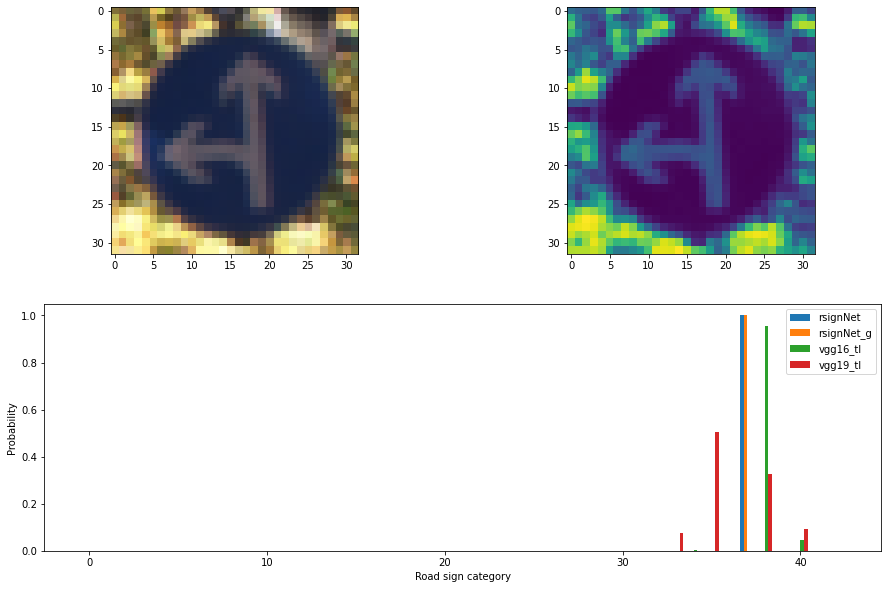

In [39]:
# image: Go straight or left
imgPredict(1)

Ground truth label: Wild animals crossing
rsignNet predicted label: Wild animals crossing
rsignNet_g predicted label: Double curve
vgg16_tl predicted label: Wild animals crossing
vgg19_tl predicted label: Bumpy road


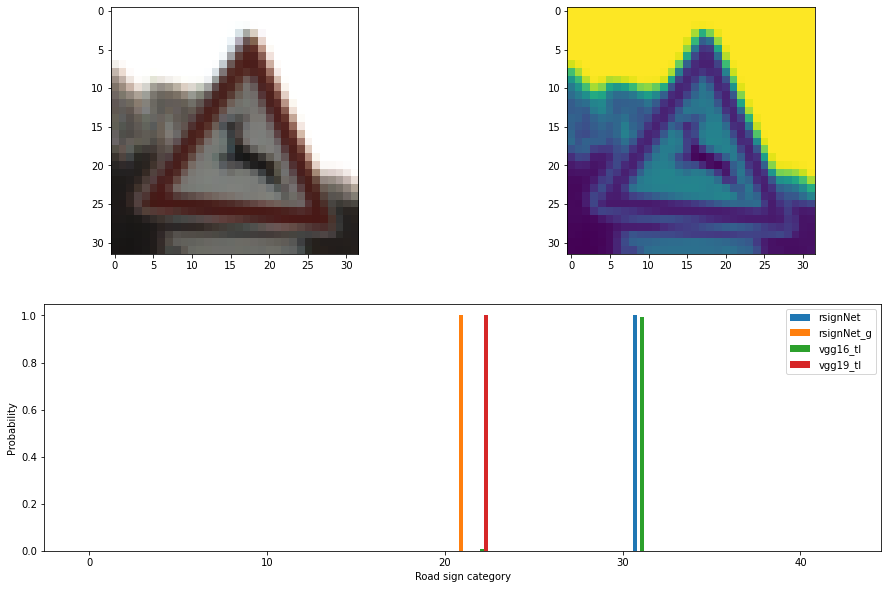

In [40]:
# image: Wild animals crossing
imgPredict(2)

# SECTION 6. Result Discussion

This project demonstrates that simple convolutional neural network can achieve reasonable accuracy classifying real world imagess. On the other hand, the poor performance of transfer learning using pre-trained CNN was rather unexpected. 

I tried to tune the hyperparameters for the fully connected layers in the two transfer learning models, but found the tolerance between underfitting and overfitting is very tight: if I increased the FC layers to 256 neurons and above, the in-sample accuracy increases dramatically while the out-of-sample accuracy stays around 0.2-0.3. Whereas when I kept the FC layers with 128 neurons or lower, the in-sample and out-of-sample doesn't diverge too much. One possible solution to this problem is to better preprocessing the image data to correct the brightness (some images are too dark or vise-a-versa) to help combat outliers.

The other interest finding is that using RGB images yielded better model performances and had shorter convergence time in the two simple CNN implementations. Color information in this case helps model generalize patterns.